### Using GPR to predict Flame Length

#### Import Libraries

In [11]:
# Sys
import os
import sys
import json
sys.path.append("..")

# Data
import pandas as pd
import numpy as np
import shap
from src.path import PATH_DATASETV1, PATH_DATA_FLAMELENGTH

# Visualization
import matplotlib.pyplot as plt

# ML
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel, DotProduct, RBF

from sklearn.metrics import mean_squared_error, r2_score

# plotting defaults
%matplotlib inline

#### Functions

In [13]:
def rmse(a,b): 
    return np.sqrt(mean_squared_error(a,b))

#### Load and combine FlameLength.xlsx and DatasetV1.xlsx

In [ ]:
# Load
df_main = pd.read_excel(PATH_DATASETV1)
df_fl = pd.read_excel(PATH_DATA_FLAMELENGTH)

# Merge on 'Name' column
df = pd.merge(df_main, df_fl, on="Name")

# show rows present only in the flame-length file
# only_in_flame = df_fl[~df_fl['Name'].isin(df_main['Name'])].copy()
# print(len(only_in_flame), "rows only in flame-length file")
print(len(df), "rows after merge")

# display IDs
# if len(only_in_flame):
#     display(only_in_flame[['Name']].head(50))
#     only_in_flame.to_csv(os.path.join(os.path.dirname(PATH_DATA_FLAMELENGTH), "only_in_flame.csv"), index=False)


# check for duplicates in merged dataframe
col = "Name"

print("Any duplicate IDs? ", df[col].duplicated().any())
print("Duplicate count (extra rows):", df[col].duplicated().sum())

# drop exact duplicates across all columns, keep first occurrence
df = df.drop_duplicates(keep="first")
print("Rows after dropping exact duplicates:", len(df))

# Rescale 'phiint' -> phi/(1+phi) and insert new column immediately after the original

# Convert to numeric just in case (non-numeric -> NaN)
phi = pd.to_numeric(df["PhiInt"], errors="coerce")

# Compute rescaled value
phi_rescaled = phi / (1 + phi)
new_col = "PhiInt_rescaled"
# Insert new column immediately after 'phiint'
idx = df.columns.get_loc("PhiInt")
df.insert(loc=idx + 1, column=new_col, value=phi_rescaled)

display(df[["PhiInt", new_col]].head(10))

def rmse(a,b): 
    return np.sqrt(mean_squared_error(a,b))

57 rows after merge
Any duplicate IDs?  True
Duplicate count (extra rows): 9
Rows after dropping exact duplicates: 48


,PhiInt,PhiInt_rescaled
0,2.008448,0.667603
1,1.997066,0.666340
2,1.996639,0.666293
3,4.027794,0.801106
4,3.979560,0.799179
5,6.012267,0.857393
6,5.999513,0.857133
7,2.003487,0.667054
8,2.039250,0.670971
9,2.012097,0.668005


#### Feature Selection

In [16]:
# feature and target selection
features = ["S1", "S2", "PhiInt_rescaled", "d1", "d2", "u1", "u2"]
# features = ["S1", "S2", "d1", "d2", "u1"]
target = "Lf (m)"  # FlameLength

X = df[features].copy()
y = df[target].copy()
print("Lf min:", y.min())
print("Lf max:", y.max())

print("Feature matrix shape:", X.shape)

Lf min: 0.021196289062499988
Lf max: 0.23560567603920982
Feature matrix shape: (48, 7)


#### Ridge Baseline - simple linear regression

In [50]:
# Ridge baseline for comparison with GPR
# StandardScaler() normalises features to mean=0, std=1
# alpha is regularization strength
pipeline_ridge = Pipeline([("scaler", StandardScaler()), ("ridge", Ridge(alpha=1.0))])
cv = KFold(n_splits=5, shuffle=True, random_state=1) # 5-fold cross-validation
ridge_scores = -cross_val_score(
    pipeline_ridge, X, y, cv=cv, scoring="neg_root_mean_squared_error"
)
print(f"Ridge CV RMSE: mean={ridge_scores.mean():.5f}, std={ridge_scores.std():.5f}")

Ridge CV RMSE: mean=0.01916, std=0.00314


mean=0.019 : relatively low RMSE   
std=0.003 : small variance across different folds means model is not sensitive to data splits  
R2 not used, misleading with small datasets.

#### Linear Kernel GPR

Linear GPR CV RMSE: mean=0.01924, std=0.00320
Linear GPR CV R2 : mean=0.9136, std=0.0366
Mean train RMSE: 0.01736
Mean test  RMSE: 0.01924
Mean train R2: 0.93633
Mean test  R2: 0.91362
OOF Coverage (% within 95% CI): 37.5%


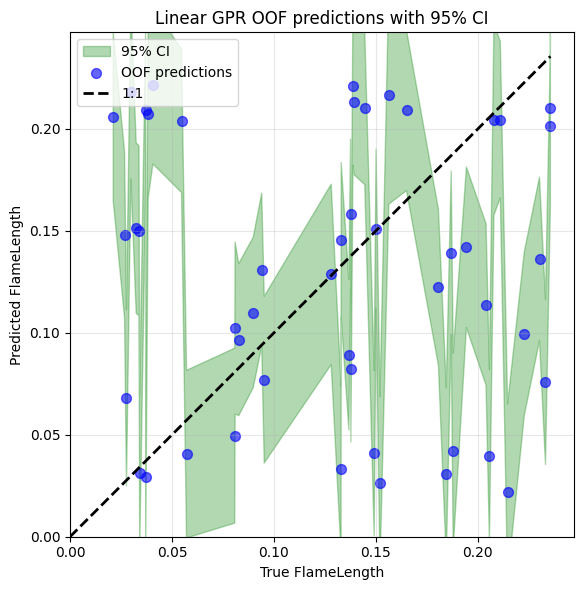

Fitted kernel: 0.255**2 * DotProduct(sigma_0=1.51e-05) + WhiteKernel(noise_level=0.0736)
Log-marginal-likelihood: -15.943698615603154
Coverage (% within 95% CI): 95.8%


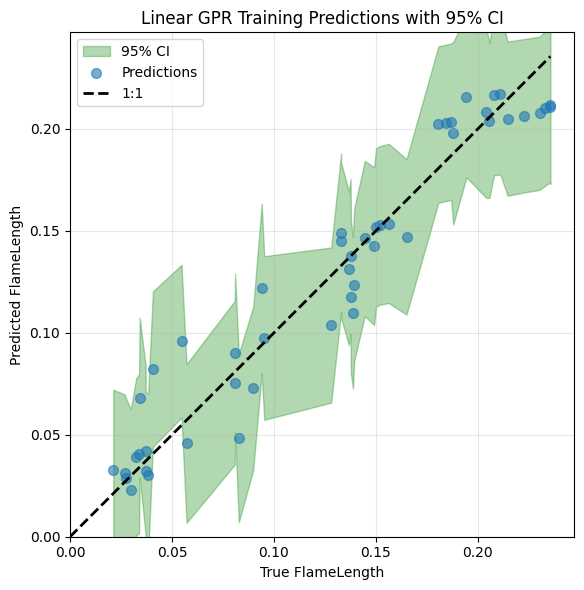

In [41]:
# GPR with Linear kernel (DotProduct) + WhiteKernel
# DotProduct kernel represents linear relationships: k(x, x') = x · x'
kernel_linear = ConstantKernel(1.0, (1e-2, 1e2)) * DotProduct(
    sigma_0=1.0, sigma_0_bounds=(1e-6, 1e1)
) + WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-6, 1e2))
# Pipeline
gpr_linear = GaussianProcessRegressor(kernel=kernel_linear, n_restarts_optimizer=8, normalize_y=True)
pipeline_gpr_linear = Pipeline([("scaler", StandardScaler()), ("gpr", gpr_linear)])

# Cross-validated RMSE (5-fold) to ensure non-biasedness of train-test split
gpr_linear_scores = -cross_val_score(
    pipeline_gpr_linear, X, y, cv=cv, scoring="neg_root_mean_squared_error", n_jobs=1
)
print(f"Linear GPR CV RMSE: mean={gpr_linear_scores.mean():.5f}, std={gpr_linear_scores.std():.5f}")
gpr_linear_r2 = cross_val_score(
    pipeline_gpr_linear, X, y, cv=cv, scoring="r2", n_jobs=1
)
print(f"Linear GPR CV R2 : mean={gpr_linear_r2.mean():.4f}, std={gpr_linear_r2.std():.4f}")

# Per-fold train/test diagnostics
fold_metrics = []
for i, (tr, te) in enumerate(cv.split(X, y), 1):
    X_tr, X_te = X.iloc[tr], X.iloc[te]
    y_tr, y_te = y.iloc[tr], y.iloc[te]
    pipeline_gpr_linear.fit(X_tr, y_tr)
    y_tr_pred = pipeline_gpr_linear.predict(X_tr)
    y_te_pred = pipeline_gpr_linear.predict(X_te)
    fold_metrics.append({
        "fold": i,
        "train_rmse": rmse(y_tr, y_tr_pred),
        "test_rmse": rmse(y_te, y_te_pred),
        "train_r2": r2_score(y_tr, y_tr_pred),
        "test_r2": r2_score(y_te, y_te_pred),
    })

fold_df = pd.DataFrame(fold_metrics)
print(f"Mean train RMSE: {fold_df.train_rmse.mean():.5f}")
print(f"Mean test  RMSE: {fold_df.test_rmse.mean():.5f}")
print(f"Mean train R2: {fold_df.train_r2.mean():.5f}")
print(f"Mean test  R2: {fold_df.test_r2.mean():.5f}")

# OOF predictions with uncertainties
y_oof_gpr_linear = []
y_oof_std_linear = []
for i, (tr, te) in enumerate(cv.split(X, y)):
    X_tr, X_te = X.iloc[tr], X.iloc[te]
    y_tr, y_te = y.iloc[tr], y.iloc[te]
    pipeline_gpr_linear.fit(X_tr, y_tr)
    X_te_scaled = pipeline_gpr_linear.named_steps["scaler"].transform(X_te)
    y_pred, y_std = pipeline_gpr_linear.named_steps["gpr"].predict(X_te_scaled, return_std=True)
    y_oof_gpr_linear.extend(y_pred)
    y_oof_std_linear.extend(y_std)

y_oof_gpr_linear = np.array(y_oof_gpr_linear)
y_oof_std_linear = np.array(y_oof_std_linear)

# Sort by true values for proper CI visualization
sort_idx = np.argsort(y.values)
y_sorted = y.values[sort_idx]
y_oof_sorted = y_oof_gpr_linear[sort_idx]
y_std_sorted = y_oof_std_linear[sort_idx]

# Calculate coverage for OOF: percentage of samples where true value falls within 95% CI
lower_bound_oof = y_oof_sorted - 1.96 * y_std_sorted
upper_bound_oof = y_oof_sorted + 1.96 * y_std_sorted
within_ci_oof = (y_sorted >= lower_bound_oof) & (y_sorted <= upper_bound_oof)
coverage_oof = 100 * within_ci_oof.sum() / len(y_sorted)

print(f"OOF Coverage (% within 95% CI): {coverage_oof:.1f}%")

# Plot OOF predictions vs true with 95% CI
plt.figure(figsize=(6, 6))
plt.fill_between(y_sorted, y_oof_sorted - 1.96 * y_std_sorted, y_oof_sorted + 1.96 * y_std_sorted, 
                 alpha=0.3, color='green', label='95% CI')
plt.scatter(y_sorted, y_oof_sorted, alpha=0.6, s=50, label="OOF predictions", color='blue')
plt.plot([0, y_sorted.max()], [0, y_sorted.max()], "k--", lw=2, label="1:1")
plt.xlabel("True FlameLength")
plt.ylabel("Predicted FlameLength")
plt.xlim(0, y_sorted.max() * 1.05)
plt.ylim(0, y_sorted.max() * 1.05)
plt.legend()
plt.title("Linear GPR OOF predictions with 95% CI")
plt.grid(True, alpha=0.3)
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()

# Fit on full data and diagnostics
pipeline_gpr_linear.fit(X, y)
gpr_linear_fitted = pipeline_gpr_linear.named_steps["gpr"]
print("Fitted kernel:", gpr_linear_fitted.kernel_)
print("Log-marginal-likelihood:", gpr_linear_fitted.log_marginal_likelihood_value_)

# Predict on training data for diagnostics
X_scaled = pipeline_gpr_linear.named_steps["scaler"].transform(X)
y_pred_linear, y_std_linear = gpr_linear_fitted.predict(X_scaled, return_std=True)
train_rmse_linear = np.sqrt(mean_squared_error(y, y_pred_linear))
train_r2_linear = r2_score(y, y_pred_linear)
# print(f"\nTrain RMSE: {train_rmse_linear:.5f}, Train R2: {train_r2_linear:.5f}")

# Sort by true values for proper visualization
sort_idx_train = np.argsort(y.values)
y_sorted_train = y.values[sort_idx_train]
y_pred_sorted = y_pred_linear[sort_idx_train]
y_std_sorted = y_std_linear[sort_idx_train]

# Calculate coverage: percentage of samples where true value falls within 95% CI
lower_bound = y_pred_linear - 1.96 * y_std_linear
upper_bound = y_pred_linear + 1.96 * y_std_linear
within_ci = (y.values >= lower_bound) & (y.values <= upper_bound)
coverage = 100 * within_ci.sum() / len(y)
print(f"Coverage (% within 95% CI): {coverage:.1f}%")

# Plot predicted vs true with 95% CI (training data on full fit)
plt.figure(figsize=(6, 6))
plt.fill_between(y_sorted_train, y_pred_sorted - 1.96 * y_std_sorted, y_pred_sorted + 1.96 * y_std_sorted, 
                 alpha=0.3, color='green', label='95% CI')
plt.scatter(y_sorted_train, y_pred_sorted, alpha=0.6, s=50, label="Predictions")
plt.plot([0, y_sorted_train.max()], [0, y_sorted_train.max()], "k--", lw=2, label="1:1")
plt.xlabel("True FlameLength")
plt.ylabel("Predicted FlameLength")
plt.xlim(0, y_sorted_train.max() * 1.05)
plt.ylim(0, y_sorted_train.max() * 1.05)
plt.legend()
plt.title("Linear GPR Training Predictions with 95% CI")
plt.grid(True, alpha=0.3)
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()

#### RBF Kernel GPR

RBF GPR CV RMSE: mean=0.01678, std=0.00507
RBF GPR CV R2 : mean=0.9281, std=0.0492
Mean train RMSE: 0.00929
Mean test  RMSE: 0.01678
Mean train R2: 0.98110
Mean test  R2: 0.92815
OOF Coverage (% within 95% CI): 35.4%


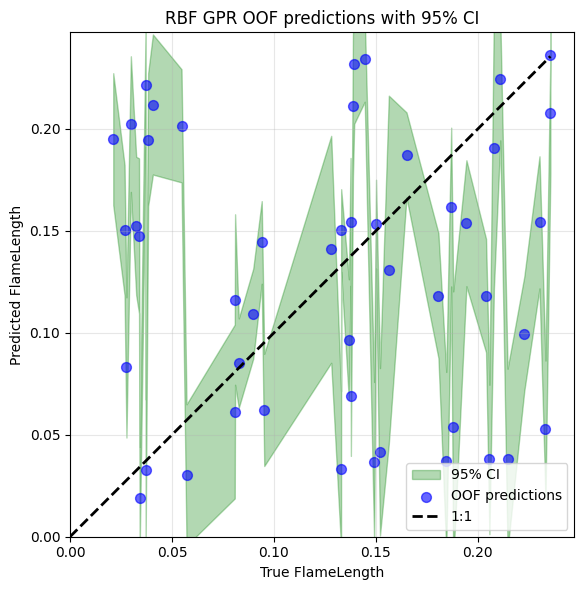

Fitted kernel: 0.787**2 * RBF(length_scale=2.15) + WhiteKernel(noise_level=0.0281)
Log-marginal-likelihood: -11.727503839961578
Coverage (% within 95% CI): 95.8%


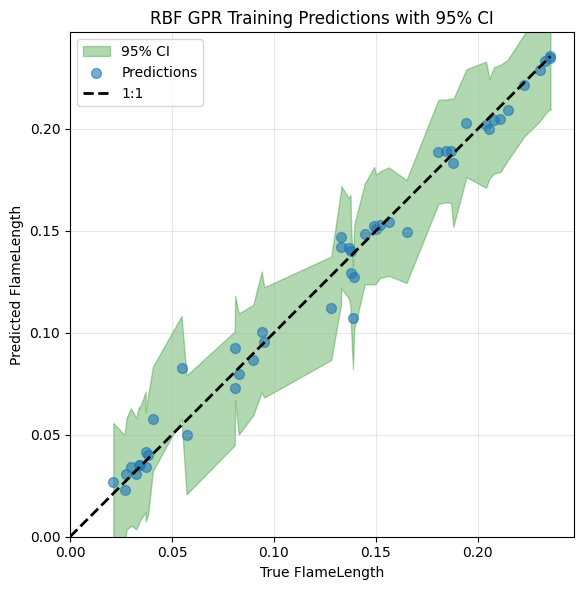

In [42]:
# GPR with RBF kernel + WhiteKernel
# RBF kernel for smooth non-linear relationships
kernel_rbf = ConstantKernel(1.0, (1e-2, 1e2)) * RBF(
    length_scale=1.0, length_scale_bounds=(1e-3, 1e3)
) + WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-6, 1e2))

gpr_rbf = GaussianProcessRegressor(kernel=kernel_rbf, n_restarts_optimizer=8, normalize_y=True)
pipeline_gpr_rbf = Pipeline([("scaler", StandardScaler()), ("gpr", gpr_rbf)])

# Cross-validated RMSE (5-fold)
gpr_rbf_scores = -cross_val_score(
    pipeline_gpr_rbf, X, y, cv=cv, scoring="neg_root_mean_squared_error", n_jobs=1
)
print(f"RBF GPR CV RMSE: mean={gpr_rbf_scores.mean():.5f}, std={gpr_rbf_scores.std():.5f}")
gpr_rbf_r2 = cross_val_score(
    pipeline_gpr_rbf, X, y, cv=cv, scoring="r2", n_jobs=1
)
print(f"RBF GPR CV R2 : mean={gpr_rbf_r2.mean():.4f}, std={gpr_rbf_r2.std():.4f}")

# Per-fold train/test diagnostics
fold_metrics_rbf = []
for i, (tr, te) in enumerate(cv.split(X, y), 1):
    X_tr, X_te = X.iloc[tr], X.iloc[te]
    y_tr, y_te = y.iloc[tr], y.iloc[te]
    pipeline_gpr_rbf.fit(X_tr, y_tr)
    y_tr_pred = pipeline_gpr_rbf.predict(X_tr)
    y_te_pred = pipeline_gpr_rbf.predict(X_te)
    fold_metrics_rbf.append({
        "fold": i,
        "train_rmse": rmse(y_tr, y_tr_pred),
        "test_rmse": rmse(y_te, y_te_pred),
        "train_r2": r2_score(y_tr, y_tr_pred),
        "test_r2": r2_score(y_te, y_te_pred),
    })

fold_df_rbf = pd.DataFrame(fold_metrics_rbf)
print(f"Mean train RMSE: {fold_df_rbf.train_rmse.mean():.5f}")
print(f"Mean test  RMSE: {fold_df_rbf.test_rmse.mean():.5f}")
print(f"Mean train R2: {fold_df_rbf.train_r2.mean():.5f}")
print(f"Mean test  R2: {fold_df_rbf.test_r2.mean():.5f}")

# OOF predictions with uncertainties
y_oof_gpr_rbf = []
y_oof_std_rbf = []
for i, (tr, te) in enumerate(cv.split(X, y)):
    X_tr, X_te = X.iloc[tr], X.iloc[te]
    y_tr, y_te = y.iloc[tr], y.iloc[te]
    pipeline_gpr_rbf.fit(X_tr, y_tr)
    X_te_scaled = pipeline_gpr_rbf.named_steps["scaler"].transform(X_te)
    y_pred, y_std = pipeline_gpr_rbf.named_steps["gpr"].predict(X_te_scaled, return_std=True)
    y_oof_gpr_rbf.extend(y_pred)
    y_oof_std_rbf.extend(y_std)

y_oof_gpr_rbf = np.array(y_oof_gpr_rbf)
y_oof_std_rbf = np.array(y_oof_std_rbf)

# Sort by true values for proper CI visualization
sort_idx_rbf = np.argsort(y.values)
y_sorted_rbf = y.values[sort_idx_rbf]
y_oof_sorted_rbf = y_oof_gpr_rbf[sort_idx_rbf]
y_std_sorted_rbf = y_oof_std_rbf[sort_idx_rbf]

# Calculate coverage for OOF
lower_bound_oof_rbf = y_oof_sorted_rbf - 1.96 * y_std_sorted_rbf
upper_bound_oof_rbf = y_oof_sorted_rbf + 1.96 * y_std_sorted_rbf
within_ci_oof_rbf = (y_sorted_rbf >= lower_bound_oof_rbf) & (y_sorted_rbf <= upper_bound_oof_rbf)
coverage_oof_rbf = 100 * within_ci_oof_rbf.sum() / len(y_sorted_rbf)

print(f"OOF Coverage (% within 95% CI): {coverage_oof_rbf:.1f}%")

# Plot OOF predictions vs true with 95% CI
plt.figure(figsize=(6, 6))
plt.fill_between(y_sorted_rbf, y_oof_sorted_rbf - 1.96 * y_std_sorted_rbf, y_oof_sorted_rbf + 1.96 * y_std_sorted_rbf, 
                 alpha=0.3, color='green', label='95% CI')
plt.scatter(y_sorted_rbf, y_oof_sorted_rbf, alpha=0.6, s=50, label="OOF predictions", color='blue')
plt.plot([0, y_sorted_rbf.max()], [0, y_sorted_rbf.max()], "k--", lw=2, label="1:1")
plt.xlabel("True FlameLength")
plt.ylabel("Predicted FlameLength")
plt.xlim(0, y_sorted_rbf.max() * 1.05)
plt.ylim(0, y_sorted_rbf.max() * 1.05)
plt.legend()
plt.title("RBF GPR OOF predictions with 95% CI")
plt.grid(True, alpha=0.3)
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()

# Fit on full data and diagnostics
pipeline_gpr_rbf.fit(X, y)
gpr_rbf_fitted = pipeline_gpr_rbf.named_steps["gpr"]
print("Fitted kernel:", gpr_rbf_fitted.kernel_)
print("Log-marginal-likelihood:", gpr_rbf_fitted.log_marginal_likelihood_value_)

# Predict on training data for diagnostics
X_scaled_rbf = pipeline_gpr_rbf.named_steps["scaler"].transform(X)
y_pred_rbf, y_std_rbf = gpr_rbf_fitted.predict(X_scaled_rbf, return_std=True)
train_rmse_rbf = np.sqrt(mean_squared_error(y, y_pred_rbf))
train_r2_rbf = r2_score(y, y_pred_rbf)

# Sort by true values for proper visualization
sort_idx_train_rbf = np.argsort(y.values)
y_sorted_train_rbf = y.values[sort_idx_train_rbf]
y_pred_sorted_rbf = y_pred_rbf[sort_idx_train_rbf]
y_std_sorted_train_rbf = y_std_rbf[sort_idx_train_rbf]

# Calculate coverage
lower_bound_rbf = y_pred_rbf - 1.96 * y_std_rbf
upper_bound_rbf = y_pred_rbf + 1.96 * y_std_rbf
within_ci_rbf = (y.values >= lower_bound_rbf) & (y.values <= upper_bound_rbf)
coverage_rbf = 100 * within_ci_rbf.sum() / len(y)
print(f"Coverage (% within 95% CI): {coverage_rbf:.1f}%")

# Plot predicted vs true with 95% CI (training data on full fit)
plt.figure(figsize=(6, 6))
plt.fill_between(y_sorted_train_rbf, y_pred_sorted_rbf - 1.96 * y_std_sorted_train_rbf, y_pred_sorted_rbf + 1.96 * y_std_sorted_train_rbf, 
                 alpha=0.3, color='green', label='95% CI')
plt.scatter(y_sorted_train_rbf, y_pred_sorted_rbf, alpha=0.6, s=50, label="Predictions")
plt.plot([0, y_sorted_train_rbf.max()], [0, y_sorted_train_rbf.max()], "k--", lw=2, label="1:1")
plt.xlabel("True FlameLength")
plt.ylabel("Predicted FlameLength")
plt.xlim(0, y_sorted_train_rbf.max() * 1.05)
plt.ylim(0, y_sorted_train_rbf.max() * 1.05)
plt.legend()
plt.title("RBF GPR Training Predictions with 95% CI")
plt.grid(True, alpha=0.3)
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()

#### Linear + RBF Kernel GPR

d:\Users\fengchonghui\Documents\chong hui\centralesupelec\Rozanoff\rozanoff_2025\rozanoff_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__sigma_0 is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
d:\Users\fengchonghui\Documents\chong hui\centralesupelec\Rozanoff\rozanoff_2025\rozanoff_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
d:\Users\fengchonghui\Documents\chong hui\centralesupelec\Rozanoff\rozanoff_2025\rozanoff_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__sigma_0 is c

Linear+RBF GPR CV RMSE: mean=0.01542, std=0.00368


d:\Users\fengchonghui\Documents\chong hui\centralesupelec\Rozanoff\rozanoff_2025\rozanoff_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__sigma_0 is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
d:\Users\fengchonghui\Documents\chong hui\centralesupelec\Rozanoff\rozanoff_2025\rozanoff_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
d:\Users\fengchonghui\Documents\chong hui\centralesupelec\Rozanoff\rozanoff_2025\rozanoff_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__sigma_0 is c

Linear+RBF GPR CV R2 : mean=0.9429, std=0.0306


d:\Users\fengchonghui\Documents\chong hui\centralesupelec\Rozanoff\rozanoff_2025\rozanoff_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__sigma_0 is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
d:\Users\fengchonghui\Documents\chong hui\centralesupelec\Rozanoff\rozanoff_2025\rozanoff_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__sigma_0 is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
d:\Users\fengchonghui\Documents\chong hui\centralesupelec\Rozanoff\rozanoff_2025\rozanoff_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is c

Mean train RMSE: 0.00243
Mean test  RMSE: 0.01540
Mean train R2: 0.99759
Mean test  R2: 0.94301


d:\Users\fengchonghui\Documents\chong hui\centralesupelec\Rozanoff\rozanoff_2025\rozanoff_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__sigma_0 is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
d:\Users\fengchonghui\Documents\chong hui\centralesupelec\Rozanoff\rozanoff_2025\rozanoff_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
d:\Users\fengchonghui\Documents\chong hui\centralesupelec\Rozanoff\rozanoff_2025\rozanoff_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__sigma_0 is c

OOF Coverage (% within 95% CI): 29.2%


d:\Users\fengchonghui\Documents\chong hui\centralesupelec\Rozanoff\rozanoff_2025\rozanoff_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__sigma_0 is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


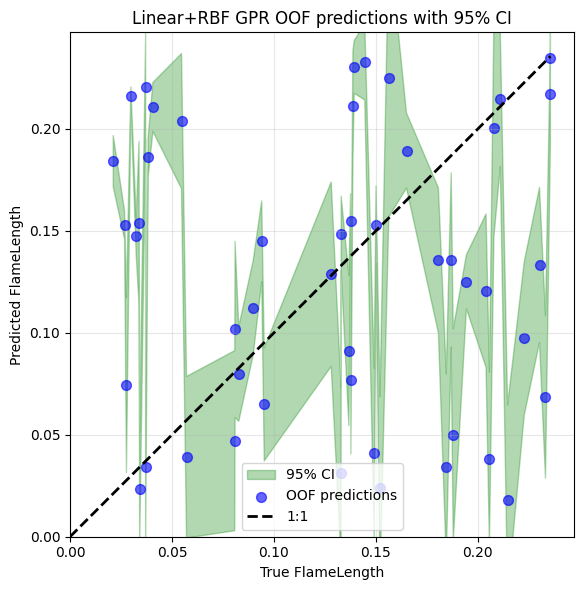

Fitted kernel: 0.278**2 * DotProduct(sigma_0=0.0001) + RBF(length_scale=0.336) + WhiteKernel(noise_level=0.00137)
Log-marginal-likelihood: -3.9203078937928595
Coverage (% within 95% CI): 100.0%


d:\Users\fengchonghui\Documents\chong hui\centralesupelec\Rozanoff\rozanoff_2025\rozanoff_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__sigma_0 is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


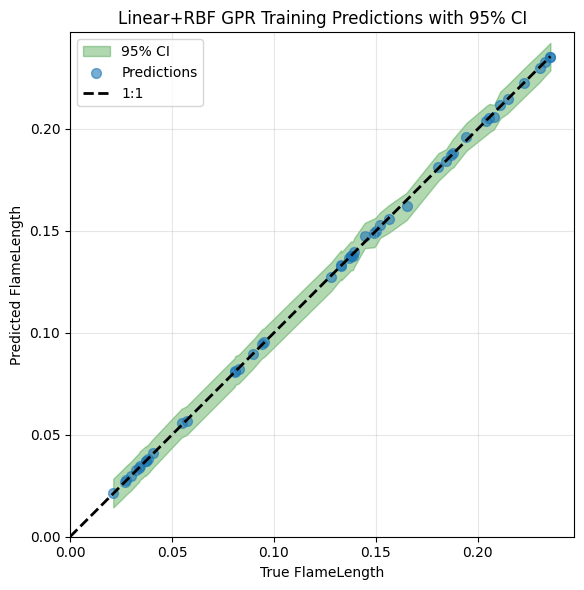

In [47]:
# GPR with Linear + RBF kernel + WhiteKernel
# Combines linear and non-linear relationships
kernel_combined = ConstantKernel(1.0, (1e-2, 1e2)) * (
    DotProduct(sigma_0=1.0, sigma_0_bounds=(1e-4, 1e1)) + 
    RBF(length_scale=1.0, length_scale_bounds=(1e-3, 1e3))
) + WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-4, 1e2))

gpr_combined = GaussianProcessRegressor(kernel=kernel_combined, n_restarts_optimizer=8, normalize_y=True)
pipeline_gpr_combined = Pipeline([("scaler", StandardScaler()), ("gpr", gpr_combined)])

# Cross-validated RMSE (5-fold)
gpr_combined_scores = -cross_val_score(
    pipeline_gpr_combined, X, y, cv=cv, scoring="neg_root_mean_squared_error", n_jobs=1
)
print(f"Linear+RBF GPR CV RMSE: mean={gpr_combined_scores.mean():.5f}, std={gpr_combined_scores.std():.5f}")
gpr_combined_r2 = cross_val_score(
    pipeline_gpr_combined, X, y, cv=cv, scoring="r2", n_jobs=1
)
print(f"Linear+RBF GPR CV R2 : mean={gpr_combined_r2.mean():.4f}, std={gpr_combined_r2.std():.4f}")

# Per-fold train/test diagnostics
fold_metrics_combined = []
for i, (tr, te) in enumerate(cv.split(X, y), 1):
    X_tr, X_te = X.iloc[tr], X.iloc[te]
    y_tr, y_te = y.iloc[tr], y.iloc[te]
    pipeline_gpr_combined.fit(X_tr, y_tr)
    y_tr_pred = pipeline_gpr_combined.predict(X_tr)
    y_te_pred = pipeline_gpr_combined.predict(X_te)
    fold_metrics_combined.append({
        "fold": i,
        "train_rmse": rmse(y_tr, y_tr_pred),
        "test_rmse": rmse(y_te, y_te_pred),
        "train_r2": r2_score(y_tr, y_tr_pred),
        "test_r2": r2_score(y_te, y_te_pred),
    })

fold_df_combined = pd.DataFrame(fold_metrics_combined)
print(f"Mean train RMSE: {fold_df_combined.train_rmse.mean():.5f}")
print(f"Mean test  RMSE: {fold_df_combined.test_rmse.mean():.5f}")
print(f"Mean train R2: {fold_df_combined.train_r2.mean():.5f}")
print(f"Mean test  R2: {fold_df_combined.test_r2.mean():.5f}")

# OOF predictions with uncertainties
y_oof_gpr_combined = []
y_oof_std_combined = []
for i, (tr, te) in enumerate(cv.split(X, y)):
    X_tr, X_te = X.iloc[tr], X.iloc[te]
    y_tr, y_te = y.iloc[tr], y.iloc[te]
    pipeline_gpr_combined.fit(X_tr, y_tr)
    X_te_scaled = pipeline_gpr_combined.named_steps["scaler"].transform(X_te)
    y_pred, y_std = pipeline_gpr_combined.named_steps["gpr"].predict(X_te_scaled, return_std=True)
    y_oof_gpr_combined.extend(y_pred)
    y_oof_std_combined.extend(y_std)

y_oof_gpr_combined = np.array(y_oof_gpr_combined)
y_oof_std_combined = np.array(y_oof_std_combined)

# Sort by true values for proper CI visualization
sort_idx_combined = np.argsort(y.values)
y_sorted_combined = y.values[sort_idx_combined]
y_oof_sorted_combined = y_oof_gpr_combined[sort_idx_combined]
y_std_sorted_combined = y_oof_std_combined[sort_idx_combined]

# Calculate coverage for OOF
lower_bound_oof_combined = y_oof_sorted_combined - 1.96 * y_std_sorted_combined
upper_bound_oof_combined = y_oof_sorted_combined + 1.96 * y_std_sorted_combined
within_ci_oof_combined = (y_sorted_combined >= lower_bound_oof_combined) & (y_sorted_combined <= upper_bound_oof_combined)
coverage_oof_combined = 100 * within_ci_oof_combined.sum() / len(y_sorted_combined)

print(f"OOF Coverage (% within 95% CI): {coverage_oof_combined:.1f}%")

# Plot OOF predictions vs true with 95% CI
plt.figure(figsize=(6, 6))
plt.fill_between(y_sorted_combined, y_oof_sorted_combined - 1.96 * y_std_sorted_combined, 
                 y_oof_sorted_combined + 1.96 * y_std_sorted_combined, 
                 alpha=0.3, color='green', label='95% CI')
plt.scatter(y_sorted_combined, y_oof_sorted_combined, alpha=0.6, s=50, label="OOF predictions", color='blue')
plt.plot([0, y_sorted_combined.max()], [0, y_sorted_combined.max()], "k--", lw=2, label="1:1")
plt.xlabel("True FlameLength")
plt.ylabel("Predicted FlameLength")
plt.xlim(0, y_sorted_combined.max() * 1.05)
plt.ylim(0, y_sorted_combined.max() * 1.05)
plt.legend()
plt.title("Linear+RBF GPR OOF predictions with 95% CI")
plt.grid(True, alpha=0.3)
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()

# Fit on full data and diagnostics
pipeline_gpr_combined.fit(X, y)
gpr_combined_fitted = pipeline_gpr_combined.named_steps["gpr"]
print("Fitted kernel:", gpr_combined_fitted.kernel_)
print("Log-marginal-likelihood:", gpr_combined_fitted.log_marginal_likelihood_value_)

# Predict on training data for diagnostics
X_scaled_combined = pipeline_gpr_combined.named_steps["scaler"].transform(X)
y_pred_combined, y_std_combined = gpr_combined_fitted.predict(X_scaled_combined, return_std=True)
train_rmse_combined = np.sqrt(mean_squared_error(y, y_pred_combined))
train_r2_combined = r2_score(y, y_pred_combined)

# Sort by true values for proper visualization
sort_idx_train_combined = np.argsort(y.values)
y_sorted_train_combined = y.values[sort_idx_train_combined]
y_pred_sorted_combined = y_pred_combined[sort_idx_train_combined]
y_std_sorted_train_combined = y_std_combined[sort_idx_train_combined]

# Calculate coverage
lower_bound_combined = y_pred_combined - 1.96 * y_std_combined
upper_bound_combined = y_pred_combined + 1.96 * y_std_combined
within_ci_combined = (y.values >= lower_bound_combined) & (y.values <= upper_bound_combined)
coverage_combined = 100 * within_ci_combined.sum() / len(y)
print(f"Coverage (% within 95% CI): {coverage_combined:.1f}%")

# Plot predicted vs true with 95% CI (training data on full fit)
plt.figure(figsize=(6, 6))
plt.fill_between(y_sorted_train_combined, y_pred_sorted_combined - 1.96 * y_std_sorted_train_combined, 
                 y_pred_sorted_combined + 1.96 * y_std_sorted_train_combined, 
                 alpha=0.3, color='green', label='95% CI')
plt.scatter(y_sorted_train_combined, y_pred_sorted_combined, alpha=0.6, s=50, label="Predictions")
plt.plot([0, y_sorted_train_combined.max()], [0, y_sorted_train_combined.max()], "k--", lw=2, label="1:1")
plt.xlabel("True FlameLength")
plt.ylabel("Predicted FlameLength")
plt.xlim(0, y_sorted_train_combined.max() * 1.05)
plt.ylim(0, y_sorted_train_combined.max() * 1.05)
plt.legend()
plt.title("Linear+RBF GPR Training Predictions with 95% CI")
plt.grid(True, alpha=0.3)
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()

#### Matern Kernel GPR

Matern GPR CV RMSE: mean=0.01720, std=0.00588
Matern GPR CV R2 : mean=0.9188, std=0.0643
Mean train RMSE: 0.00385
Mean test  RMSE: 0.01788
Mean train R2: 0.99655
Mean test  R2: 0.91857
OOF Coverage (% within 95% CI): 31.2%


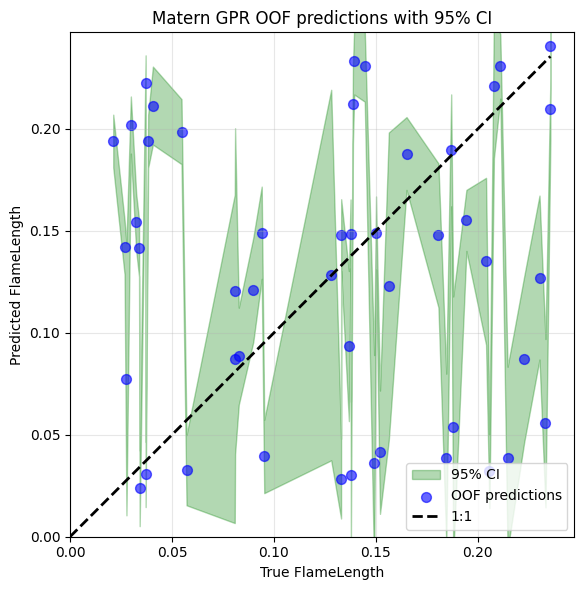

Fitted kernel: 0.678**2 * Matern(length_scale=[1.94, 0.938, 13.9, 1.89, 4, 1.93, 6.84e+04], nu=2.5) + WhiteKernel(noise_level=0.0125)
Log-marginal-likelihood: -2.786628678720568
Coverage (% within 95% CI): 97.9%


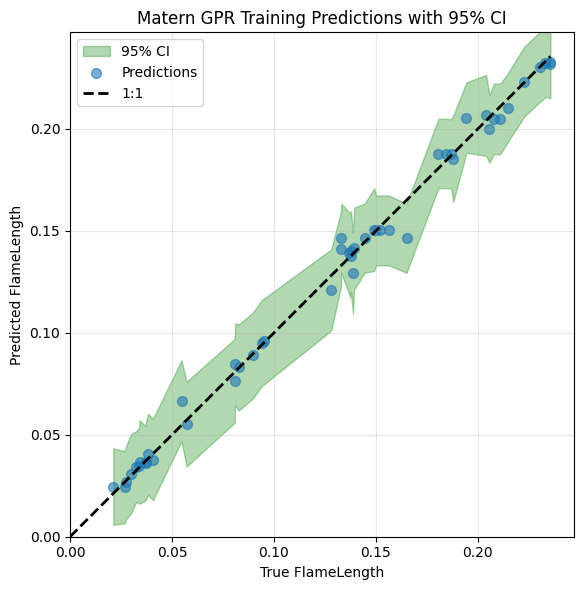

In [49]:
# GPR with Matern (ARD) + WhiteKernel; use ARD by passing a vector length_scale
kernel_matern = ConstantKernel(1.0, (1e-2, 1e2)) * Matern(
    length_scale=np.ones(X.shape[1]), length_scale_bounds=(1e-3, 1e6), nu=2.5
) + WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-6, 1e2))

gpr_matern = GaussianProcessRegressor(kernel=kernel_matern, n_restarts_optimizer=8, normalize_y=True)
pipeline_gpr_matern = Pipeline([("scaler", StandardScaler()), ("gpr", gpr_matern)])

# Cross-validated RMSE (5-fold)
gpr_matern_scores = -cross_val_score(
    pipeline_gpr_matern, X, y, cv=cv, scoring="neg_root_mean_squared_error", n_jobs=1
)
print(f"Matern GPR CV RMSE: mean={gpr_matern_scores.mean():.5f}, std={gpr_matern_scores.std():.5f}")
gpr_matern_r2 = cross_val_score(
    pipeline_gpr_matern, X, y, cv=cv, scoring="r2", n_jobs=1
)
print(f"Matern GPR CV R2 : mean={gpr_matern_r2.mean():.4f}, std={gpr_matern_r2.std():.4f}")

# Per-fold train/test diagnostics
fold_metrics_matern = []
for i, (tr, te) in enumerate(cv.split(X, y), 1):
    X_tr, X_te = X.iloc[tr], X.iloc[te]
    y_tr, y_te = y.iloc[tr], y.iloc[te]
    pipeline_gpr_matern.fit(X_tr, y_tr)
    y_tr_pred = pipeline_gpr_matern.predict(X_tr)
    y_te_pred = pipeline_gpr_matern.predict(X_te)
    fold_metrics_matern.append({
        "fold": i,
        "train_rmse": rmse(y_tr, y_tr_pred),
        "test_rmse": rmse(y_te, y_te_pred),
        "train_r2": r2_score(y_tr, y_tr_pred),
        "test_r2": r2_score(y_te, y_te_pred),
    })

fold_df_matern = pd.DataFrame(fold_metrics_matern)
print(f"Mean train RMSE: {fold_df_matern.train_rmse.mean():.5f}")
print(f"Mean test  RMSE: {fold_df_matern.test_rmse.mean():.5f}")
print(f"Mean train R2: {fold_df_matern.train_r2.mean():.5f}")
print(f"Mean test  R2: {fold_df_matern.test_r2.mean():.5f}")

# OOF predictions with uncertainties
y_oof_gpr_matern = []
y_oof_std_matern = []
for i, (tr, te) in enumerate(cv.split(X, y)):
    X_tr, X_te = X.iloc[tr], X.iloc[te]
    y_tr, y_te = y.iloc[tr], y.iloc[te]
    pipeline_gpr_matern.fit(X_tr, y_tr)
    X_te_scaled = pipeline_gpr_matern.named_steps["scaler"].transform(X_te)
    y_pred, y_std = pipeline_gpr_matern.named_steps["gpr"].predict(X_te_scaled, return_std=True)
    y_oof_gpr_matern.extend(y_pred)
    y_oof_std_matern.extend(y_std)

y_oof_gpr_matern = np.array(y_oof_gpr_matern)
y_oof_std_matern = np.array(y_oof_std_matern)

# Sort by true values for proper CI visualization
sort_idx_matern = np.argsort(y.values)
y_sorted_matern = y.values[sort_idx_matern]
y_oof_sorted_matern = y_oof_gpr_matern[sort_idx_matern]
y_std_sorted_matern = y_oof_std_matern[sort_idx_matern]

# Calculate coverage for OOF
lower_bound_oof_matern = y_oof_sorted_matern - 1.96 * y_std_sorted_matern
upper_bound_oof_matern = y_oof_sorted_matern + 1.96 * y_std_sorted_matern
within_ci_oof_matern = (y_sorted_matern >= lower_bound_oof_matern) & (y_sorted_matern <= upper_bound_oof_matern)
coverage_oof_matern = 100 * within_ci_oof_matern.sum() / len(y_sorted_matern)

print(f"OOF Coverage (% within 95% CI): {coverage_oof_matern:.1f}%")

# Plot OOF predictions vs true with 95% CI
plt.figure(figsize=(6, 6))
plt.fill_between(y_sorted_matern, y_oof_sorted_matern - 1.96 * y_std_sorted_matern, 
                 y_oof_sorted_matern + 1.96 * y_std_sorted_matern, 
                 alpha=0.3, color='green', label='95% CI')
plt.scatter(y_sorted_matern, y_oof_sorted_matern, alpha=0.6, s=50, label="OOF predictions", color='blue')
plt.plot([0, y_sorted_matern.max()], [0, y_sorted_matern.max()], "k--", lw=2, label="1:1")
plt.xlabel("True FlameLength")
plt.ylabel("Predicted FlameLength")
plt.xlim(0, y_sorted_matern.max() * 1.05)
plt.ylim(0, y_sorted_matern.max() * 1.05)
plt.legend()
plt.title("Matern GPR OOF predictions with 95% CI")
plt.grid(True, alpha=0.3)
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()

# Fit on full data and diagnostics
pipeline_gpr_matern.fit(X, y)
gpr_matern_fitted = pipeline_gpr_matern.named_steps["gpr"]
print("Fitted kernel:", gpr_matern_fitted.kernel_)
print("Log-marginal-likelihood:", gpr_matern_fitted.log_marginal_likelihood_value_)

# Predict on training data for diagnostics
X_scaled_matern = pipeline_gpr_matern.named_steps["scaler"].transform(X)
y_pred_matern, y_std_matern = gpr_matern_fitted.predict(X_scaled_matern, return_std=True)
train_rmse_matern = np.sqrt(mean_squared_error(y, y_pred_matern))
train_r2_matern = r2_score(y, y_pred_matern)

# Sort by true values for proper visualization
sort_idx_train_matern = np.argsort(y.values)
y_sorted_train_matern = y.values[sort_idx_train_matern]
y_pred_sorted_matern = y_pred_matern[sort_idx_train_matern]
y_std_sorted_train_matern = y_std_matern[sort_idx_train_matern]

# Calculate coverage
lower_bound_matern = y_pred_matern - 1.96 * y_std_matern
upper_bound_matern = y_pred_matern + 1.96 * y_std_matern
within_ci_matern = (y.values >= lower_bound_matern) & (y.values <= upper_bound_matern)
coverage_matern = 100 * within_ci_matern.sum() / len(y)
print(f"Coverage (% within 95% CI): {coverage_matern:.1f}%")

# Plot predicted vs true with 95% CI (training data on full fit)
plt.figure(figsize=(6, 6))
plt.fill_between(y_sorted_train_matern, y_pred_sorted_matern - 1.96 * y_std_sorted_train_matern, 
                 y_pred_sorted_matern + 1.96 * y_std_sorted_train_matern, 
                 alpha=0.3, color='green', label='95% CI')
plt.scatter(y_sorted_train_matern, y_pred_sorted_matern, alpha=0.6, s=50, label="Predictions")
plt.plot([0, y_sorted_train_matern.max()], [0, y_sorted_train_matern.max()], "k--", lw=2, label="1:1")
plt.xlabel("True FlameLength")
plt.ylabel("Predicted FlameLength")
plt.xlim(0, y_sorted_train_matern.max() * 1.05)
plt.ylim(0, y_sorted_train_matern.max() * 1.05)
plt.legend()
plt.title("Matern GPR Training Predictions with 95% CI")
plt.grid(True, alpha=0.3)
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()

In [14]:
# inspect length-scales from fitted kernel
kernel_repr = gpr_fitted.kernel_
print("Kernel repr:", kernel_repr)

# Try to extract length_scale values from the kernel string if structured; otherwise print kernel and infer
# Note: sklearn exposes parameters via kernel_.get_params() but the nested structure can differ
params = gpr_fitted.kernel_.get_params()
# look for attributes named 'length_scale' in params
ls = {k: v for k, v in params.items() if "length_scale" in k}
print("Length-scale params found:", ls)

Kernel repr: 0.682**2 * Matern(length_scale=[2.01, 1.02, 1.57, 4.01, 1.91], nu=2.5) + WhiteKernel(noise_level=0.015)
Length-scale params found: {'k1__k2__length_scale': array([2.00981286, 1.02346459, 1.57216109, 4.00744902, 1.91031002]), 'k1__k2__length_scale_bounds': (0.001, 1000.0)}


In [15]:
# Cell 11: save cleaned merged data and trained pipeline
out_csv = os.path.join(os.path.dirname(PATH_DATASETV1), "merged_cleaned_with_flame.csv")
df.to_csv(out_csv, index=False)
print("Saved merged data to", out_csv)

import joblib

model_path = os.path.join(os.path.dirname(PATH_DATASETV1), "gpr_pipeline.joblib")
joblib.dump(pipeline_gpr, model_path)
print("Saved pipeline to", model_path)

Saved merged data to d:\Users\fengchonghui\Documents\chong hui\centralesupelec\Rozanoff\rozanoff_2025\flame_length_pred\..\original_data\merged_cleaned_with_flame.csv
Saved pipeline to d:\Users\fengchonghui\Documents\chong hui\centralesupelec\Rozanoff\rozanoff_2025\flame_length_pred\..\original_data\gpr_pipeline.joblib


In [17]:
print(y_std)
print(len(y_std))

[0.01039137 0.011548   0.00981552 0.00957599 0.00986693 0.00997893
 0.01033406 0.01098697 0.01080201 0.00952913 0.01092639 0.01093028
 0.01092339 0.01099126 0.0113595  0.01140538 0.01099105 0.01092785
 0.01089305 0.01094095 0.01130428 0.01178625 0.0116848  0.01168582
 0.01178833 0.00942107 0.00938039 0.00942058 0.00938412 0.00942087
 0.01128175 0.0093573  0.00937924 0.00948108 0.00941659 0.00948762
 0.00949173 0.00941454 0.00952594 0.00948084 0.00923984 0.00936212
 0.0118323  0.00928833 0.0095293  0.00956169 0.00941687 0.00952704]
48
